# MORPHOLOGY TEST

In [1]:
import numpy as np
from matplotlib import pyplot, cm
from neuron import h, gui
from neuron.units import mV, ms, sec, um

%matplotlib inline
# c compiler
#!nrnivmodl vecevent.mod
#!nrnivmodl L5bPCmodelsEH/mod/

In [26]:
def createSynapse(dend,dendIdx, loc=0.5, tau=[2*ms, 4*ms], e=0*mV):
    """Creates an excitatory synapse on the dendrite given by Idx."""
    syn = h.Exp2Syn(dend[dendIdx](loc))
    syn.tau1 = tau[0]
    syn.tau2 = tau[1]
    syn.e = e
    return syn 

def createStim(isi=20*ms, num=100, start=1*ms, noise=1, seed=9):
    stim = h.NetStim()
    stim.interval = isi
    stim.number = num
    stim.start = start
    stim.noise = noise
    stim.noiseFromRandom123(seed, 0, 0)
    stim.seed(seed)
    
    return stim

def connectStim(syn, stim, delay=1*ms, weight=0.4):
    conn = h.NetCon(stim, syn)
    conn.delay = delay
    conn.weight[0] = weight
    
    return conn

def createStim(isi=20*ms, num=100, start=1*ms, noise=1, seed=9):
        stim = h.NetStim()
        stim.interval = isi
        stim.number = num
        stim.start = start
        stim.noise = noise
        stim.noiseFromRandom123(seed, 0, 0)
        stim.seed(seed)
        return stim

def homogeneous_poisson(rate, tmax, bin_size):
    "Rate in Hz, Tmax and bin_size in ms"
    
    nbins = np.floor(tmax/bin_size).astype(int)
    
    prob_of_spike = rate * bin_size / 1e3 #In ms^-1
    
    spikes = np.random.rand(nbins) < prob_of_spike
    
    return spikes * 1

def Background_noise(rate,bin_size,tmax,numInputs):

    BoolTS = homogeneous_poisson(rate, tmax, bin_size)
    
    return [np.where(BoolTS==1)[0]*bin_size for i in range(numInputs)],BoolTS

def CreateVecStim(numInputs,tmax,rate=10,bin_size=0.1):

    Noise,BoolTS = Background_noise(rate,bin_size,tmax,numInputs)

    stimulations = [h.VecStim() for i in range(numInputs)]

    Noivec = [h.Vector(Noise[i]) for i in range(numInputs)]

    for i in range(numInputs):
        
        stimulations[i].play(Noivec[i])
    
    return stimulations,Noise,BoolTS

np.random.seed(12345)


In [3]:

def CorrInputs(tmax,rate,Nsour=2,bin_size=1,a=0,b=1000):
    
    Noiseb,BoolTS = Background_noise(rate,bin_size,tmax,1)
    
    NoiseCorr = []
    
    NoiseCorr.append(np.int32(np.round(Noiseb[0])))
    
    for i in range(Nsour-1):

        DerI = np.int32(np.round(Noiseb[0] + np.random.normal(a,b,len(Noiseb))))

        #Inputs should be inside the simulation time interval
        DerI *= 1*(DerI >= 0)*(DerI < tmax)

        #Delete inputs at 0 s
        DerI = [i for i in DerI if i!=0]

        NoiseCorr.append(np.array(DerI))
    
    stimulationsSour = [h.VecStim() for i in range(Nsour)]

    NoivecS = [h.Vector(NoiseCorr[i]) for i in range(Nsour)]

    for i in range(Nsour):
        
        stimulationsSour[i].play(NoivecS[i])
    
    return stimulationsSour

def BooleanInputInfo(NoiseCorrt,tmax,bin_size,numSour):
    
    St = np.arange(0,tmax,bin_size)

    Sbool = np.zeros([numSour,St.shape[0]],dtype=np.int8)

    for i in range(len(NoiseCorrt)):

        for j in NoiseCorrt[i]:

            Sbool[i,np.where(St==j)] = 1
    
    return Sbool

from scipy.ndimage import gaussian_filter1d
import numpy as np

def InputCorr(Inputs):
    
    S = np.zeros([len(Inputs),len(Inputs[0])])

    sigma = 1

    for i in range(len(Inputs)):

        S[i,np.where(Inputs[i]==1)[0]] = 1
        S[i,np.where((S[1:]-S[:-1])==1)[0]] = 0.5
        S[i,np.where((S[1:]-S[:-1])==-1)[0]+1] = 0.5

        S[i] = gaussian_filter1d(S[i],sigma)

    cor = np.corrcoef(S[0],S[1])[0,1]

    return cor

def EI_Synaptic_info(numNoiseInputs,tauE,tauI):
    
    pp = [0.8,0.2]

    es = [0,-80]

    ee = np.random.choice(es,numNoiseInputs,p=pp)

    tau = np.zeros([ee.shape[0],2])

    tau[np.where(ee<0)] = tauI
    tau[np.where(ee>=0)] = tauE
    
    return ee,tau


In [4]:

def ShanonEntropy(X):
    
    if len(X.shape)>1:
        t,size = X.shape
        
        base = np.array([2**i for i in range(size)])

        Xst = np.dot(X,base)

    else:
        size = 1
        
        Xst = 1*X
    
    states,counts = np.unique(Xst,return_counts=True)

    H = 0

    for i in range(len(states)):

        p = counts[i]/np.sum(counts)

        H += -p*np.log(p)
    
    return H

def IMf(x,y):
    
    h1 = ShanonEntropy(x)
    
    h2 = ShanonEntropy(y)

    h3 = ShanonEntropy(np.column_stack((x,y)))

    return h1+h2-h3

def PID(T,X):
    
    RR = np.min([IMf(T,X[:,0]),IMf(T,X[:,1])])
    
    ru1 = IMf(X[:,0],T)
    ru2 = IMf(X[:,1],T)
        
    U1 = ru1 - RR

    U2 = ru2 - RR
    
    Syn = IMf(X,T) - ru1 - ru2 + RR
        
    return [RR,U1,U2,Syn]

def PID_analysis(recordings,Input_bin_size=1,thres=-30,tau=1,Timebining=1,skip=2000):
    
    tmax = int(np.round(recordings["time"][-1]))
    
    numSour = len(recordings["inputTime"])
    
    Inputs = BooleanInputInfo(recordings["inputTime"],tmax,Input_bin_size,numSour)
    
    Vsoma = 1*(recordings["soma"] > thres)[ini:]

    t = recordings["time"]

    dt = np.mean(t[1:]-t[:-1])
    
    tw = int(np.round(Input_bin_size/dt))
    
    Ts0 = int(len(Vsoma)/tw)
    
    bolskip = int(ini*dt/Input_bin_size)
    
    T = int((len(Inputs[0])-bolskip)/Timebining)

    #Equalize input and soma time series    
    Somabool = np.zeros(Ts0,dtype=np.int8)
    
    for i in range(Ts0-1):

        Somabool[i] = np.sum(Vsoma[tw*i:tw*(i+1)])>0
    
    ######################################
    SS = [Somabool]
    
    for i in range(len(Inputs)):
        
        SS.append(Inputs[i][bolskip:])
    
    timeS = np.zeros([len(SS),T],dtype=np.int32)
    
    for j in range(len(SS)):

        for i in range(T-1):

            timeS[j,i] = np.int32(1*(np.sum(SS[j][i*Timebining:(i+1)*Timebining])>0))
    
    T = timeS[0,tau:]

    Xs = timeS[1:,:-tau].T

    Red,U1,U2,Syn = PID(T,Xs)
    
    cor = InputCorr(Inputs)

    return [Red,np.max([U1,U2]),Syn,cor]


In [5]:
h.nrn_load_dll("x86_64/vecevent.so")



0.0

In [6]:

#filename = "DATA/Pyrp22.hoc"

#h.load_file(filename)

ddir = "L5bPCmodelsEH/"

h.load_file("import3d.hoc")
h.load_file("nrngui.hoc")
h.load_file(ddir+"init.hoc")

morphology_file = ddir+"morphologies/cell1.asc"

h.load_file(ddir+"models/L5PCbiophys3.hoc")
h.load_file(ddir+"models/L5PCtemplate.hoc")

h.L5PCtemplate(morphology_file)

#allsec = h.allsec()



	0 
	1 


L5PCtemplate[0]

In [7]:
#INITIALIZE PARAMETERS
"""
Vrest = -70*mV

# membrane properties are defined here */
membranecap = 0.638856    # specific membrane capacitance in uF cm^-2 */
membraneresist = 120236.0 # specific membrane resistance in ohm cm^2 */
axialresist = 141.949     # axial resistivity in ohm cm */

# dend sections
dend = [s for s in allsec if s.name().startswith('dend')]

for sec in dend:
    
    sec.insert('pas')
    sec.e_pas=Vrest
    sec.g_pas = 5.34/membraneresist
    
    sec.Ra = axialresist
    sec.cm = 5.34*membranecap

Soma = [s for s in allsec if s.name().startswith('soma')]

for sec in Soma:

    sec.insert('hh')
    
    sec.Ra = axialresist
    sec.cm = 1.0*membranecap

    for seg in sec:
        seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
        seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
        seg.hh.gl = 0.0003    # Leak conductance in S/cm2
        seg.hh.el = -54.3     # Reversal potential in mV
"""


"\nVrest = -70*mV\n\n# membrane properties are defined here */\nmembranecap = 0.638856    # specific membrane capacitance in uF cm^-2 */\nmembraneresist = 120236.0 # specific membrane resistance in ohm cm^2 */\naxialresist = 141.949     # axial resistivity in ohm cm */\n\n# dend sections\ndend = [s for s in allsec if s.name().startswith('dend')]\n\nfor sec in dend:\n    \n    sec.insert('pas')\n    sec.e_pas=Vrest\n    sec.g_pas = 5.34/membraneresist\n    \n    sec.Ra = axialresist\n    sec.cm = 5.34*membranecap\n\nSoma = [s for s in allsec if s.name().startswith('soma')]\n\nfor sec in Soma:\n\n    sec.insert('hh')\n    \n    sec.Ra = axialresist\n    sec.cm = 1.0*membranecap\n\n    for seg in sec:\n        seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2\n        seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2\n        seg.hh.gl = 0.0003    # Leak conductance in S/cm2\n        seg.hh.el = -54.3     # Reversal potential in mV\n"

In [18]:
import pandas as pd

#List = pd.read_csv("DATA/Section_List.csv")
List = pd.read_csv("DATA/List_dist.csv")

CellName = List["Cell"][0]

#filename = "DATA/Pyrp22.hoc"

#h.load_file(filename) 

allsec = h.allsec()

#dend = [s for s in allsec if s.name().startswith('dend')]

dend = [s for s in allsec if 'dend' in str(s.name())]
apic = [s for s in allsec if 'apic' in str(s.name())]

Soma = [s for s in allsec if 'soma' in str(s.name())]


In [20]:

#SELECTING SECTION FOR BACKGROUND NOISE
def Select_Noise_sections(List,dend,Cell="Pyr_p1",typ="dend",rangeL=[0,1500],numNoiseInputs=100):
    
    Cell0 = List[(List['Cell']==Cell)&(List['Names'].str.contains(typ))]

    #For background noise
    rangeL = [0,1500]

    SecNames = Cell0[(Cell0['L']>rangeL[0])&(Cell0['L']<rangeL[1])].Names.values

    dendIdx0 = []

    for i in range(len(dend)):
        sec = dend[i]
        if str(sec) in SecNames:
            dendIdx0.append(i)
    
    dendIdx = np.random.choice(dendIdx0,numNoiseInputs)
    
    return dendIdx

#SELECTING SECTION FOR INPUTs
def Select_Input_sections(List,dendIdx,dend,typ="dend",Cell="Pyr_p1",rangeL=[0,50],numInputs=2):
    #For sources
    rangeL = [0,50]
    
    Cell0 = List[(List['Cell']==Cell)&(List['Names'].str.contains(typ))]

    SecNamesSour = Cell0[(Cell0['L']>rangeL[0])&(Cell0['L']<rangeL[1])].Names.values

    dendIdxSour0 = []

    for i in range(len(dend)):
        sec = dend[i]
        if str(sec) in SecNamesSour:
            dendIdxSour0.append(i)   

    dendIdxSour = np.random.choice(dendIdxSour0,numInputs,replace=False)
    
    #To avoid selecting a section in noise input sections
    Crit = True
    while Crit:
        for a in dendIdxSour:
            if a in dendIdx:
                dendIdxSour[:] = np.random.choice(dendIdxSour0,numInputs,replace=False)
            else:
                Crit = False
    
    return dendIdxSour


In [31]:
rate = 10

tmax = 12000 #ms

#Number of sources
numSour = 2

#Parameters for decorrelate inputs
noiM = 0 #Mean of time deviation (gaussian dist)
noiStd = 10#Standart deviation of time deviation (gaussian dist)

#NUmber of noisy synapses and inputs
numNoiseInputs = 100

numNoiseInputsApic = 20

dt = 0.0125

h.dt = dt

#Parameters
loc = 0.5
e = 0
delay = 0
weight = 0.05

#Different time constants for E and I synapses
tauE = [2,4]
tauI = [2,5]

dendIdx = Select_Noise_sections(List,dend,typ="dend",Cell=CellName,numNoiseInputs=numNoiseInputs)

apicIdx = Select_Noise_sections(List,apic,typ="apic",Cell=CellName,numNoiseInputs=numNoiseInputsApic)

#dendIdxSour = Select_Input_sections(List,dendIdx,apic,typ="apic",rangeL=[0,1500])

apicIdxSour = Select_Input_sections(List,apicIdx,apic,typ="apic",rangeL=[0,1500])

ee,tau = EI_Synaptic_info(numNoiseInputs,tauE,tauI)

ee1,tau1 = EI_Synaptic_info(numNoiseInputsApic,tauE,tauI)

import matplotlib.pyplot as plt

#Creating Input (spiking time)
stimulationsCorr = CorrInputs(tmax,rate)

#stimulationsCorr is a Neuron object


In [32]:

# input stimulus (NetStim) parameters
isi=10*ms         # mean interspike time interval
num=10            # average number of spikes
start=1*ms        # stimulus start time
stop=tmax*ms      # simulation stop time
noise=1         # noise parameter (must be a value from 0 to 1)

seeds=np.random.randint(10000, size=numNoiseInputs)

seeds1=np.random.randint(10000, size=numNoiseInputsApic)


In [33]:
#BACKGROUND NOISE
# create synapses
synapses = [createSynapse(dend,dendIdx[i], loc=loc, tau=tau[i], e=ee[i]) for i in range(numNoiseInputs)]

# create inputs
stimulations = [createStim(isi=isi, num=num, start=start, noise=noise, seed=seeds[i]) for i in range(numNoiseInputs)]

# connect inputs to synapses
connections = [connectStim(synapses[i], stimulations[i], delay=delay, weight=weight) for i in range(numNoiseInputs)]

synapses1 = [createSynapse(apic,apicIdx[i], loc=loc, tau=tau1[i], e=ee1[i]) for i in range(numNoiseInputsApic)]

# create inputs
stimulations1 = [createStim(isi=isi, num=num, start=start, noise=noise, seed=seeds1[i]) for i in range(numNoiseInputsApic)]

# connect inputs to synapses
connections1 = [connectStim(synapses1[i], stimulations1[i], delay=delay, weight=weight) for i in range(numNoiseInputsApic)]

#SOURCES
# create synapses
synapsesSour = [createSynapse(apic,apicIdxSour[i], loc=loc, tau=tauE, e=0.) for i in range(numSour)]

# connect inputs to synapses
connectionsSour = [connectStim(synapsesSour[i], stimulationsCorr[i], delay=delay, weight=weight) for i in range(numSour)]


In [34]:
# prepare output variable
recordings = {'soma': h.Vector(),
              'input': [h.Vector() for i in range(numSour)],
              'inputTime': [h.Vector() for i in range(numSour)],
              'dendrite': [h.Vector() for i in range(numSour)],
              'synapse': [h.Vector() for i in range(numSour)],
              'time': h.Vector()}

# set up recordings
recordings['soma'].record(Soma[0](0.5)._ref_v) # soma membrane potential
recordings['time'].record(h._ref_t) # time steps

for i, dend0 in enumerate(dendIdxSour):
    recordings['dendrite'][i].record(dend[dend0](0.5)._ref_v)
    recordings['synapse'][i].record(synapsesSour[i]._ref_i)
    connectionsSour[i].record(recordings['inputTime'][i], recordings['input'][i])


In [35]:
tmax

12000

In [36]:
h.finitialize(-65 * mV)

h.continuerun(tmax)


0.0

In [37]:
# convert outputs into numpy arrays
for k,v in recordings.items():
    if k=='soma' or k=='time':
        recordings[k] = np.array(list(recordings[k]))
    else:
        recordings[k] = [np.array(list(recordings[k][i])) for i in range(len(recordings[k]))]


In [38]:
ini = 0


/tmp/ipykernel_3410/3221097049.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('winter')


Text(0, 0.5, 'input id')

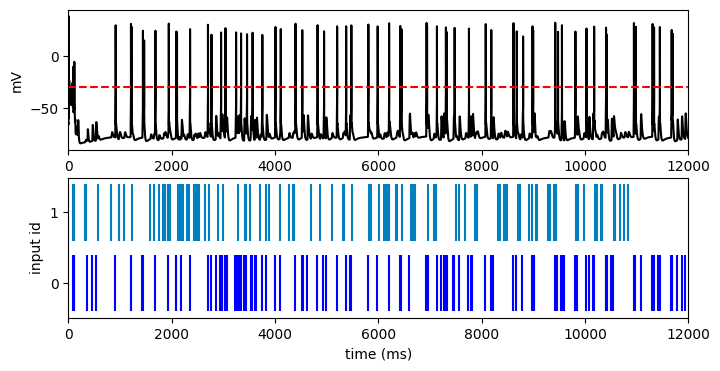

In [39]:
fig,ax = pyplot.subplots(2,1,figsize=(8,4)) # Default figsize is (8,6)

soma_plot = ax[0].plot(recordings["time"], recordings["soma"], color='black')

thres = -30

ax[0].hlines(thres,0,tmax,color="red",linestyle='dashed')

ax[0].set_xlim(ini, tmax)
ax[0].set_xlabel('time (ms)')
ax[0].set_ylabel('mV')

cmap = cm.get_cmap('winter')
spacing = cmap.N//numSour

colours = cmap(np.arange(0, cmap.N, spacing))
    
# rasterplot with input stimuli
for i in range(2):
    ax[1].vlines(recordings['inputTime'][i], i-0.4, i+0.4, colors=colours[i])  

ax[1].set_yticks(range(len(recordings['input'])))
ax[1].set_xlim(ini, tmax)
ax[1].set_xlabel('time (ms)')
ax[1].set_ylabel('input id')


In [40]:
import pickle

filename = "DATA/Sim_Pyr_p1_dt_"+str(dt)+"_tmax_"+str(tmax)

# opening file in write mode (binary) 
file = open(filename, "wb") 
  
# serializing dictionary  
pickle.dump(recordings, file) 

# closing the file 
file.close()

In [41]:
#Time bin
Ttb = np.arange(0,30,1)

Ttb[0] = 1

PIDS = []

for tb in Ttb:

    PIDs = PID_analysis(recordings,tau=1,Timebining=tb)
    
    PIDS.append(PIDs)


Inputs correlation= -0.014523172273738628


Text(0, 0.5, 'Information (bits)')

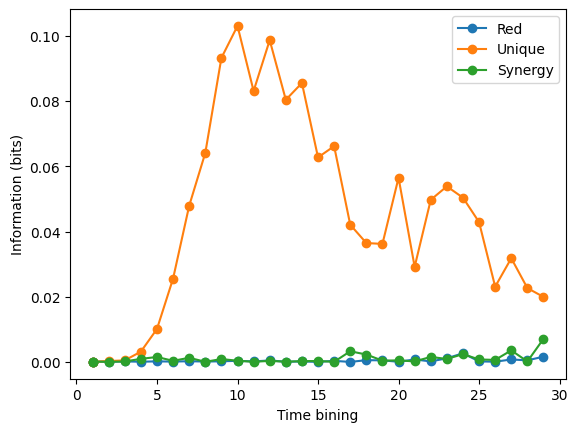

In [42]:
labels = ["Red","Unique","Synergy"]

PIDS = np.array(PIDS)

for i in range(len(labels)):
    
    plt.plot(Ttb,PIDS[:,i],'o-',label=labels[i])

plt.legend()

print("Inputs correlation=",np.mean(PIDS[:,-1]))

plt.xlabel("Time bining")
plt.ylabel("Information (bits)")


In [43]:
#Timebin that maximize information atom measured
MaxTimeBin = Ttb[np.where(PIDS == np.max(PIDS[:,:3]))[0][0]]

MaxTimeBin

10

In [44]:
#Time bin
Taus = np.arange(1,30,1)

PIDSt = []

for taus in Taus:

    PIDst = PID_analysis(recordings,tau=taus,Timebining=1)
    
    PIDSt.append(PIDst)


Inputs correlation= -0.01452317227373863


Text(0, 0.5, 'Information (bits)')

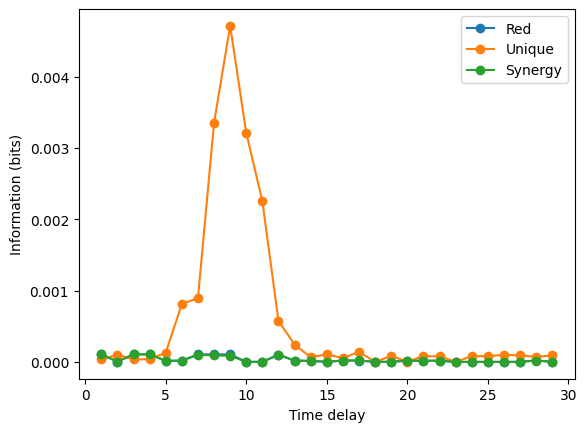

In [45]:
labels = ["Red","Unique","Synergy"]

PIDSt = np.array(PIDSt)

for i in range(len(labels)):
    
    plt.plot(Taus,PIDSt[:,i],'-o',label=labels[i])

plt.legend()

print("Inputs correlation=",np.mean(PIDSt[:,-1]))

plt.xlabel("Time delay")
plt.ylabel("Information (bits)")


In [46]:
#Delay that maximize information atom measured
MaxTau = Taus[np.where(PIDSt == np.max(PIDSt[:,:3]))[0][0]]

MaxTau

9